In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data

import random, os, pathlib, time
from tqdm import tqdm
from sklearn import datasets

In [17]:
import nflib
from nflib.flows import SequentialFlow, NormalizingFlow, ActNorm, ActNorm2D, AffineConstantFlow
import nflib.coupling_flows as icf
import nflib.inn_flow as inn
import nflib.res_flow as irf

In [18]:
from torch import distributions
from torch.distributions import MultivariateNormal

In [19]:
device = torch.device("cuda:0")
# device = torch.device("cpu")

## MNIST dataset

In [20]:
import mylibrary.datasets as datasets
# import mylibrary.nnlib as tnn

In [21]:
mnist = datasets.FashionMNIST()
# mnist.download_mnist()
# mnist.save_mnist()
train_data, train_label_, test_data, test_label_ = mnist.load()

train_data = train_data / 255.
test_data = test_data / 255.

# train_label = tnn.Logits.index_to_logit(train_label_)
train_size = len(train_label_)

In [22]:
## converting data to pytorch format
train_data = torch.Tensor(train_data)
test_data = torch.Tensor(test_data)
train_label = torch.LongTensor(train_label_)
test_label = torch.LongTensor(test_label_)

In [23]:
input_size = 784
output_size = 10

In [24]:
class MNIST_Dataset(data.Dataset):
    
    def __init__(self, data, label):
        self.data = data.reshape(-1, 1, 28, 28)
        self.label = label
        
#         self.label = mask.type(torch.float32).reshape(-1,1)
        self._shuffle_data_()
        
    def __len__(self):
        return len(self.data)
    
    def _shuffle_data_(self):
        randidx = random.sample(range(len(self.data)), k=len(self.data))
        self.data = self.data[randidx]
        self.label = self.label[randidx]
    
    def __getitem__(self, idx):
        img, lbl = self.data[idx], self.label[idx]
        return img, lbl

In [25]:
train_dataset = MNIST_Dataset(train_data, train_label)
test_dataset = MNIST_Dataset(test_data, test_label)

In [26]:
batch_size = 50
train_loader = data.DataLoader(dataset=train_dataset, num_workers=4, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, num_workers=4, batch_size=batch_size, shuffle=False)

In [27]:
class ConnectedClassifier_Linear(nn.Module):
    
    def __init__(self,input_dim, num_sets, output_dim, inv_temp=1):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_sets = num_sets
        self.inv_temp = nn.Parameter(torch.ones(1)*inv_temp)
        
        self.linear = nn.Linear(input_dim, num_sets)
#         self.linear.bias.data *= 0
        self.linear.weight.data *= 0.1
#         self.cls_weight = nn.Parameter(torch.randn(num_sets, output_dim)/output_dim)

        init_val = torch.randn(num_sets, output_dim)*0.01
        for ns in range(num_sets):
            init_val[ns, ns%output_dim] = 0.1
        self.cls_weight = nn.Parameter(init_val)
        
        self.cls_confidence = None
        
        
    def forward(self, x, hard=False):
#         self.cls_weight.data = torch.abs(self.cls_weight.data/self.cls_weight.data.sum(dim=1, keepdim=True))
        
        x = self.linear(x)
        if hard:
            x = torch.softmax(x*1e5, dim=1)
        else:
            x = torch.softmax(x*self.inv_temp, dim=1)
        self.cls_confidence = x
        c = torch.softmax(self.cls_weight, dim=1)
#         c = self.cls_weight
        return x@c ## since both are normalized, it is also normalized

In [28]:
class ConnectedClassifier_SoftKMeans(nn.Module):
    
    def __init__(self,input_dim, num_sets, output_dim, inv_temp=1):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_sets = num_sets
        self.inv_temp = nn.Parameter(torch.ones(1)*inv_temp)
        
        self.centers = nn.Parameter(torch.rand(num_sets, input_dim)*2-1)
        
        init_val = torch.randn(num_sets, output_dim)*0.01
        for ns in range(num_sets):
            init_val[ns, ns%output_dim] = 0.1
#             init_val[ns, 0] = 2. ### initialize same class in all clusters

        self.cls_weight = nn.Parameter(init_val)
        self.cls_confidence = None
        
        
    def forward(self, x, hard=False):
        self.cls_weight.data = torch.abs(self.cls_weight.data)/self.cls_weight.data.sum(dim=1, keepdim=True)
        
        x = x[:, :self.input_dim]
        dists = torch.cdist(x, self.centers)
        dists = dists/np.sqrt(self.input_dim) ### correction to make diagonal of unit square 1 in nD space
        
        if hard:
            x = torch.softmax(-dists*1e5, dim=1)
        else:
            x = torch.softmax(-dists*self.inv_temp, dim=1)
        self.cls_confidence = x
#         c = torch.softmax(self.cls_weight, dim=1)
        c = self.cls_weight
        return x@c ## since both are normalized, it is also normalized
    
    def set_centroid_to_data_randomly(self, data_loader, model):
        indices = np.random.permutation(len(data_loader.dataset.data))[:self.centers.shape[0]]
        xx = data_loader.dataset.data[indices].to(self.centers.device)
        yy = data_loader.dataset.label[indices].to(self.centers.device)
        yout = model(xx)
        self.centers.data = yout
        
        init_val = torch.ones(self.num_sets, self.output_dim)/self.output_dim
        for ns in range(len(indices)):
            init_val[ns, yy[ns]] = 1.
        self.cls_weight.data = init_val.to(self.cls_weight.device)
        pass

In [29]:
# actf = nn.SELU
# flows = [
#     nn.Conv2d(1, 32, kernel_size=3, padding=1, bias=False),
#     nn.BatchNorm2d(32),
#     actf(),
#     nn.Conv2d(32, 64, kernel_size=5, padding=2, bias=False),
#     nn.BatchNorm2d(64),
#     actf(),
#     nn.Conv2d(64, 64, kernel_size=5, padding=2, bias=False),
#     nn.BatchNorm2d(64),
#     actf(),
#     nn.Conv2d(64, 64, kernel_size=5, padding=2, bias=False),
#     nn.BatchNorm2d(64),
#     actf(),
#     nn.Conv2d(64, 1, kernel_size=5, padding=2),
#     actf(),
#     irf.Flatten(img_size=(1, 28, 28)),
#     nn.BatchNorm1d(1*28*28),
#         ]

# model = nn.Sequential(*flows)

In [30]:
# model(torch.randn(3, 1, 28, 28)).shape

In [31]:
actf = irf.Swish
flows = [
    ActNorm2D(1),
    irf.ConvResidualFlow(1, [16], activation=actf),
    irf.InvertiblePooling(2),
    ActNorm2D(4),
    irf.ConvResidualFlow(4, [64], activation=actf),
    irf.InvertiblePooling(2),
    ActNorm2D(16),
    irf.ConvResidualFlow(16, [64, 64], activation=actf),
    irf.Flatten(img_size=(16, 7, 7)),
    ActNorm(16*7*7),
        ]

model = SequentialFlow(flows)

In [32]:
# actf = irf.Swish
# flows = [
#     nn.BatchNorm2d(1),
#     irf.ConvResidualFlow(1, [16], activation=actf),
#     irf.InvertiblePooling(2),
#     nn.BatchNorm2d(4),
#     irf.ConvResidualFlow(4, [64], activation=actf),
#     irf.InvertiblePooling(2),
#     nn.BatchNorm2d(16),
#     irf.ConvResidualFlow(16, [64, 64], activation=actf),
#     irf.Flatten(img_size=(16, 7, 7)),
#     nn.BatchNorm1d(16*7*7),
#         ]

# model = nn.Sequential(*flows)

In [33]:
def get_children(module):
    child = list(module.children())
    if len(child) == 0:
        return [module]
    children = []
    for ch in child:
        grand_ch = get_children(ch)
        children+=grand_ch
    return children

In [34]:
def remove_spectral_norm(model):
    for child in get_children(model):
        if hasattr(child, 'weight'):
            print("Yes", child)
            try:
                nn.utils.remove_spectral_norm(child)
                print("Success")
            except:
                print("Failed")

In [35]:
# remove_spectral_norm(model)

In [36]:
# model = nn.Sequential(nn.Linear(784, 784, bias=False),
#                       nn.BatchNorm1d(784),
#                       nn.SELU(),
#                       nn.Linear(784, 784, bias=False),
#                       nn.BatchNorm1d(784),
#                       nn.SELU(),
#                      )

In [37]:
model.to(device)

SequentialFlow(
  (flows): ModuleList(
    (0): ActNorm2D()
    (1): ConvResidualFlow(
      (resblock): ModuleList(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): Swish()
        (2): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (2): InvertiblePooling()
    (3): ActNorm2D()
    (4): ConvResidualFlow(
      (resblock): ModuleList(
        (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): Swish()
        (2): Conv2d(64, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (5): InvertiblePooling()
    (6): ActNorm2D()
    (7): ConvResidualFlow(
      (resblock): ModuleList(
        (0): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): Swish()
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): Swish()
        (4): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )


In [38]:
xx = iter(test_loader).next()[0]
model(xx.to(device)).shape

torch.Size([50, 784])

In [39]:
for p in model.parameters():
    print(p.device)
    break

cuda:0


In [40]:
# actf = irf.Swish
# _flows = [
#     ActNorm(2),
#     irf.ResidualFlow(2, [20, 20], activation=actf),
#     ActNorm(2),
#         ]
# _clasf = SequentialFlow(_flows)
# _clasf = nn.Sequential(nn.Linear(784, 2), _clasf)

# classifier = nn.Sequential(
#                 nn.Linear(784, 2),
# #                 _clasf,
#                 ConnectedClassifier_SoftKMeans(2, 20, 10)
# #                 ConnectedClassifier_Linear(2, 100, 10)
#             )


classifier = nn.Sequential(
                nn.Linear(784, 2),
                nn.Sequential(
                    nn.Linear(2, 20), nn.SiLU(), nn.Linear(20, 10)
                ),
            )

In [41]:
# classifier = ConnectedClassifier_SoftKMeans(784, 100, 10)
# classifier = ConnectedClassifier_Softmax(784, 100, 10)
classifier = classifier.to(device)

## Model Train

In [42]:
# classifier[1].set_centroid_to_data_randomly(train_loader, nn.Sequential(model, classifier[0]))

In [43]:
learning_rate = 0.0003

In [44]:
# criterion = nn.NLLLoss()
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(list(model.parameters())+list(classifier.parameters()), lr=learning_rate)
# optimizer = optim.SGD(model.parameters(), lr=0.1)

print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  62035


In [45]:
# for p in model.parameters():
#     print(torch.isnan(p).type(torch.float32).sum())

In [46]:
# model(torch.randn(10, 784).to(device)).shape

In [47]:
xx = iter(test_loader).next()[0]
xx.shape

torch.Size([50, 1, 28, 28])

In [48]:
losses = []
train_accs = []
test_accs = []
best_model = nn.Sequential(model, classifier).state_dict()
model_name = "invmlp_fmnist_2D_v0"
EPOCHS = 50

In [49]:
index = 0
best_acc = -1
for epoch in range(EPOCHS):
    train_acc = 0
    train_count = 0
    model.train()
    for xx, yy in tqdm(train_loader):
        xx, yy = xx.to(device), yy.to(device)
#     for xx, yy in tqdm(test_loader):

        yout = model(xx)
#         print(yout)
        yout = classifier(yout)    
#         print(yout)
        loss = criterion(yout, yy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(float(loss))

        outputs = torch.argmax(yout, dim=1).data.cpu().numpy()
        correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
        train_acc += correct
        train_count += len(outputs)
#         break

    train_accs.append(float(train_acc)/train_count*100)
    train_acc = 0
    train_count = 0

    print(f'Epoch: {epoch}:{index},  Loss:{float(loss)}')
    test_count = 0
    test_acc = 0
    model.eval()
    for xx, yy in tqdm(test_loader):
        xx, yy = xx.to(device), yy.to(device)
        with torch.no_grad():
            yout = classifier(model(xx))    
        outputs = torch.argmax(yout, dim=1).data.cpu().numpy()
        correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
        test_acc += correct
        test_count += len(xx)
    test_accs.append(float(test_acc)/test_count*100)
    if test_accs[-1] > best_acc:
        print('Saving..')
        state = {'model': nn.Sequential(model, classifier).state_dict(),'acc': test_accs[-1],'epoch': epoch,}
        if not os.path.isdir('models'):
            os.mkdir('models')
        torch.save(state, f'./models/{model_name}.pth')
        best_acc = test_accs[-1]
    print(f'Train Acc:{train_accs[-1]:.2f}%, Test Acc:{test_accs[-1]:.2f}%')
    print()

### after each class index is finished training
print(f'\t-> Train Acc {max(train_accs)} ; Test Acc {max(test_accs)}')

100%|████████████████████████████████████████████████| 1200/1200 [00:10<00:00, 117.15it/s]


Epoch: 0:0,  Loss:0.35083281993865967


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 311.32it/s]


Saving..
Train Acc:64.99%, Test Acc:77.83%



100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 122.34it/s]


Epoch: 1:0,  Loss:0.4950273036956787


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 319.49it/s]


Saving..
Train Acc:79.49%, Test Acc:79.77%



100%|████████████████████████████████████████████████| 1200/1200 [00:10<00:00, 117.78it/s]


Epoch: 2:0,  Loss:0.4102531671524048


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 326.41it/s]


Saving..
Train Acc:82.07%, Test Acc:82.01%



100%|████████████████████████████████████████████████| 1200/1200 [00:10<00:00, 119.11it/s]


Epoch: 3:0,  Loss:0.8786616325378418


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 307.11it/s]


Train Acc:83.77%, Test Acc:81.87%



100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 122.43it/s]


Epoch: 4:0,  Loss:0.45147189497947693


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 313.72it/s]


Saving..
Train Acc:84.74%, Test Acc:84.15%



100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 122.65it/s]


Epoch: 5:0,  Loss:0.28502508997917175


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 321.70it/s]


Train Acc:85.67%, Test Acc:83.41%



100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 121.69it/s]


Epoch: 6:0,  Loss:0.5292105078697205


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 317.10it/s]


Saving..
Train Acc:86.40%, Test Acc:84.48%



100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 121.63it/s]


Epoch: 7:0,  Loss:0.3484940826892853


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 324.49it/s]


Saving..
Train Acc:86.90%, Test Acc:85.40%



100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 121.85it/s]


Epoch: 8:0,  Loss:0.4127408564090729


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 320.81it/s]


Saving..
Train Acc:87.59%, Test Acc:85.58%



100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 122.43it/s]


Epoch: 9:0,  Loss:0.2928471267223358


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 315.80it/s]


Train Acc:88.22%, Test Acc:85.45%



100%|████████████████████████████████████████████████| 1200/1200 [00:10<00:00, 118.98it/s]


Epoch: 10:0,  Loss:0.34783074259757996


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 318.35it/s]


Saving..
Train Acc:88.57%, Test Acc:86.23%



100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 120.53it/s]


Epoch: 11:0,  Loss:0.29580071568489075


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 327.16it/s]


Saving..
Train Acc:89.17%, Test Acc:86.50%



100%|████████████████████████████████████████████████| 1200/1200 [00:10<00:00, 118.49it/s]


Epoch: 12:0,  Loss:0.21076896786689758


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 320.90it/s]


Saving..
Train Acc:89.55%, Test Acc:86.94%



100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 120.56it/s]


Epoch: 13:0,  Loss:0.23052431643009186


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 311.81it/s]


Train Acc:89.83%, Test Acc:86.44%



100%|████████████████████████████████████████████████| 1200/1200 [00:10<00:00, 118.18it/s]


Epoch: 14:0,  Loss:0.14420302212238312


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 316.12it/s]


Train Acc:90.33%, Test Acc:86.49%



100%|████████████████████████████████████████████████| 1200/1200 [00:10<00:00, 118.12it/s]


Epoch: 15:0,  Loss:0.2075517475605011


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 318.34it/s]


Train Acc:90.76%, Test Acc:86.83%



100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 120.40it/s]


Epoch: 16:0,  Loss:0.4935549199581146


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 318.60it/s]


Saving..
Train Acc:91.08%, Test Acc:87.35%



100%|████████████████████████████████████████████████| 1200/1200 [00:10<00:00, 117.99it/s]


Epoch: 17:0,  Loss:0.2696487009525299


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 305.86it/s]


Train Acc:91.36%, Test Acc:86.76%



100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 121.07it/s]


Epoch: 18:0,  Loss:0.1452283263206482


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 324.08it/s]


Train Acc:91.69%, Test Acc:87.04%



100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 122.49it/s]


Epoch: 19:0,  Loss:0.24480363726615906


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 312.50it/s]


Saving..
Train Acc:91.97%, Test Acc:87.46%



100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 120.22it/s]


Epoch: 20:0,  Loss:0.2560056447982788


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 322.53it/s]


Saving..
Train Acc:92.17%, Test Acc:87.48%



100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 121.10it/s]


Epoch: 21:0,  Loss:0.19944390654563904


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 313.93it/s]


Train Acc:92.43%, Test Acc:87.29%



100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 122.49it/s]


Epoch: 22:0,  Loss:0.08446147292852402


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 314.72it/s]


Saving..
Train Acc:92.75%, Test Acc:87.76%



100%|████████████████████████████████████████████████| 1200/1200 [00:10<00:00, 119.39it/s]


Epoch: 23:0,  Loss:0.12129449844360352


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 318.88it/s]


Train Acc:93.00%, Test Acc:86.96%



100%|████████████████████████████████████████████████| 1200/1200 [00:10<00:00, 118.25it/s]


Epoch: 24:0,  Loss:0.0907512828707695


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 320.87it/s]


Train Acc:93.24%, Test Acc:87.23%



100%|████████████████████████████████████████████████| 1200/1200 [00:10<00:00, 118.17it/s]


Epoch: 25:0,  Loss:0.23109149932861328


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 313.67it/s]


Train Acc:93.37%, Test Acc:87.45%



100%|████████████████████████████████████████████████| 1200/1200 [00:10<00:00, 117.79it/s]


Epoch: 26:0,  Loss:0.2008674442768097


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 323.00it/s]


Train Acc:93.66%, Test Acc:87.44%



100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 120.93it/s]


Epoch: 27:0,  Loss:0.10876761376857758


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 310.44it/s]


Train Acc:93.80%, Test Acc:87.63%



100%|████████████████████████████████████████████████| 1200/1200 [00:10<00:00, 119.07it/s]


Epoch: 28:0,  Loss:0.27895331382751465


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 324.35it/s]


Train Acc:94.15%, Test Acc:87.29%



100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 121.25it/s]


Epoch: 29:0,  Loss:0.22314628958702087


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 322.44it/s]


Train Acc:94.26%, Test Acc:87.35%



100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 121.06it/s]


Epoch: 30:0,  Loss:0.20931854844093323


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 320.90it/s]


Train Acc:94.52%, Test Acc:86.92%



100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 120.78it/s]


Epoch: 31:0,  Loss:0.2111988514661789


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 314.19it/s]


Train Acc:94.67%, Test Acc:87.05%



100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 120.44it/s]


Epoch: 32:0,  Loss:0.07952391356229782


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 311.29it/s]


Train Acc:94.88%, Test Acc:87.19%



100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 121.73it/s]


Epoch: 33:0,  Loss:0.07245520502328873


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 321.94it/s]


Train Acc:95.03%, Test Acc:87.03%



100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 121.50it/s]


Epoch: 34:0,  Loss:0.3142968416213989


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 321.67it/s]


Train Acc:95.19%, Test Acc:87.18%



100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 121.85it/s]


Epoch: 35:0,  Loss:0.3103243410587311


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 316.79it/s]


Train Acc:95.33%, Test Acc:87.13%



100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 122.57it/s]


Epoch: 36:0,  Loss:0.12776492536067963


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 316.95it/s]


Train Acc:95.47%, Test Acc:87.37%



100%|████████████████████████████████████████████████| 1200/1200 [00:10<00:00, 118.50it/s]


Epoch: 37:0,  Loss:0.1630803346633911


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 330.04it/s]


Train Acc:95.55%, Test Acc:87.02%



100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 120.34it/s]


Epoch: 38:0,  Loss:0.16016890108585358


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 325.46it/s]


Train Acc:95.71%, Test Acc:87.23%



100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 122.28it/s]


Epoch: 39:0,  Loss:0.15616996586322784


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 321.91it/s]


Train Acc:95.86%, Test Acc:87.03%



100%|████████████████████████████████████████████████| 1200/1200 [00:10<00:00, 119.52it/s]


Epoch: 40:0,  Loss:0.09293196350336075


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 310.27it/s]


Train Acc:95.79%, Test Acc:87.40%



100%|████████████████████████████████████████████████| 1200/1200 [00:10<00:00, 117.93it/s]


Epoch: 41:0,  Loss:0.16363607347011566


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 313.33it/s]


Train Acc:96.15%, Test Acc:86.84%



100%|████████████████████████████████████████████████| 1200/1200 [00:10<00:00, 119.04it/s]


Epoch: 42:0,  Loss:0.17911115288734436


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 316.87it/s]


Train Acc:96.22%, Test Acc:87.27%



100%|████████████████████████████████████████████████| 1200/1200 [00:10<00:00, 117.64it/s]


Epoch: 43:0,  Loss:0.13131222128868103


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 304.77it/s]


Train Acc:96.25%, Test Acc:86.86%



100%|████████████████████████████████████████████████| 1200/1200 [00:10<00:00, 119.70it/s]


Epoch: 44:0,  Loss:0.08110694587230682


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 313.68it/s]


Train Acc:96.43%, Test Acc:86.92%



100%|████████████████████████████████████████████████| 1200/1200 [00:10<00:00, 118.56it/s]


Epoch: 45:0,  Loss:0.0924009308218956


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 314.40it/s]


Train Acc:96.52%, Test Acc:86.93%



100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 121.54it/s]


Epoch: 46:0,  Loss:0.16742640733718872


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 311.04it/s]


Train Acc:96.66%, Test Acc:87.15%



100%|████████████████████████████████████████████████| 1200/1200 [00:10<00:00, 117.25it/s]


Epoch: 47:0,  Loss:0.029051607474684715


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 320.47it/s]


Train Acc:96.64%, Test Acc:86.71%



100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 122.36it/s]


Epoch: 48:0,  Loss:0.14624160528182983


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 310.33it/s]


Train Acc:96.83%, Test Acc:86.34%



100%|████████████████████████████████████████████████| 1200/1200 [00:09<00:00, 121.86it/s]


Epoch: 49:0,  Loss:0.02418641373515129


100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 308.21it/s]

Train Acc:96.80%, Test Acc:86.53%

	-> Train Acc 96.82666666666667 ; Test Acc 87.76


In [35]:
asdasd

NameError: name 'asdasd' is not defined

In [36]:
classifier[1].inv_temp#, classifier[1].power 

Parameter containing:
tensor([12.9152], device='cuda:0', requires_grad=True)

### Hard test accuracy with count per classifier

In [50]:
model.eval()

SequentialFlow(
  (flows): ModuleList(
    (0): ActNorm2D()
    (1): ConvResidualFlow(
      (resblock): ModuleList(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): Swish()
        (2): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (2): InvertiblePooling()
    (3): ActNorm2D()
    (4): ConvResidualFlow(
      (resblock): ModuleList(
        (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): Swish()
        (2): Conv2d(64, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (5): InvertiblePooling()
    (6): ActNorm2D()
    (7): ConvResidualFlow(
      (resblock): ModuleList(
        (0): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): Swish()
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): Swish()
        (4): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )


In [38]:
test_count = 0
test_acc = 0
# set_count = torch.zeros(classifier.num_sets).to(device)
set_count = torch.zeros(classifier[1].num_sets).to(device)
for xx, yy in tqdm(test_loader):
    xx, yy = xx.to(device), yy.to(device)
    with torch.no_grad():
#         yout = classifier(model(xx), hard=True)
        yout = classifier[1](classifier[0](model(xx)), hard=True)
    
#         set_indx, count = torch.unique(torch.argmax(classifier.cls_confidence, dim=1), return_counts=True) 
        set_indx, count = torch.unique(torch.argmax(classifier[1].cls_confidence, dim=1), return_counts=True)
    
        set_count[set_indx] += count
    outputs = torch.argmax(yout, dim=1).data.cpu().numpy()
    correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
    test_acc += correct
    test_count += len(xx)

print(f'Hard Test Acc:{float(test_acc)/test_count*100:.2f}%')
print(set_count.type(torch.long).tolist())

100%|██████████| 200/200 [00:00<00:00, 297.52it/s]

Hard Test Acc:88.12%
[1006, 92, 952, 463, 442, 29, 2, 40, 1019, 9, 0, 966, 0, 1, 985, 997, 986, 72, 949, 990]


In [39]:
#### Classifiers that enclose any data
torch.count_nonzero(set_count)

tensor(18, device='cuda:0')

In [52]:
embeddings, labels, ilabels = [], [], []
model.eval()
for xx, yy in tqdm(test_loader):
    ilabels.append(yy)
    xx, yy = xx.to(device), yy.to(device)
    with torch.no_grad():
#         yout = classifier(model(xx), hard=True)
        embs = classifier[0](model(xx))
        embeddings.append(embs.cpu())
        
#         yout = classifier[1](embs, hard=True)
        yout = classifier[1](embs)
        labels.append(torch.argmax(yout, dim=1).cpu())
        
        
    

embeddings = torch.cat(embeddings, dim=0)
labels = torch.cat(labels, dim=0)
ilabels = torch.cat(ilabels, dim=0)
# maxims = torch.cat(maxims, dim=0)

100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 277.67it/s]


In [41]:
## Plot scatter plot of images
# https://nextjournal.com/ml4a/image-t-sne

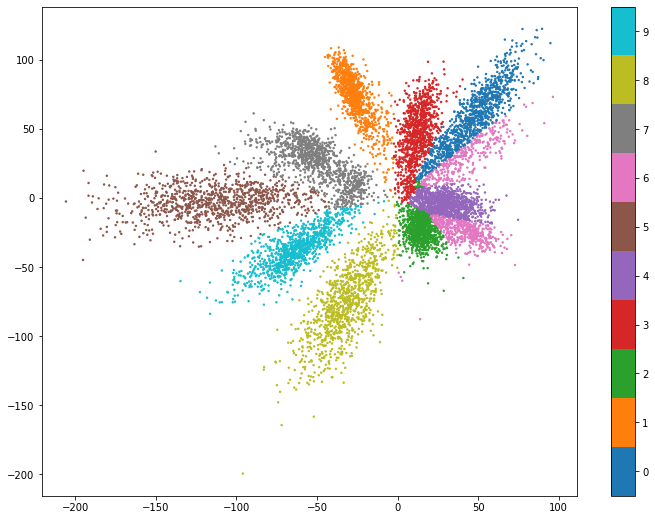

In [53]:
plt.figure(figsize=(12,9))
plt.scatter(embeddings[:,0], embeddings[:, 1], c=labels, s=2, cmap='tab10')

cbar = plt.colorbar(ticks=range(10), #label='classes', 
                    boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(list(range(10)))

# plt.savefig('./output/01_prediction_fmnist.pdf')

In [43]:
# fig, ax = plt.subplots(1, figsize=(12, 9))
# plt.scatter(embeddings[:,0], embeddings[:, 1], c=ilabels, s=2, cmap='tab10')

# plt.setp(ax, xticks=[], yticks=[])
# cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
# cbar.set_ticks(np.arange(10))
# cbar.set_ticklabels(list(range(10)))

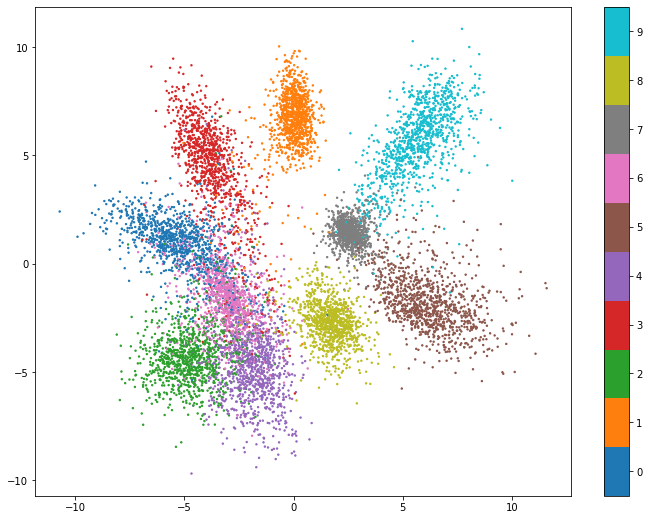

In [44]:
plt.figure(figsize=(12,9))
plt.scatter(embeddings[:,0], embeddings[:, 1], c=ilabels, s=2, cmap='tab10')

cbar = plt.colorbar(ticks=range(10), #label='classes', 
                    boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(list(range(10)))

plt.savefig('./output/02_ground_truth_fmnist_mlp.pdf')

In [45]:
torch.count_nonzero(labels==ilabels)

tensor(8812)

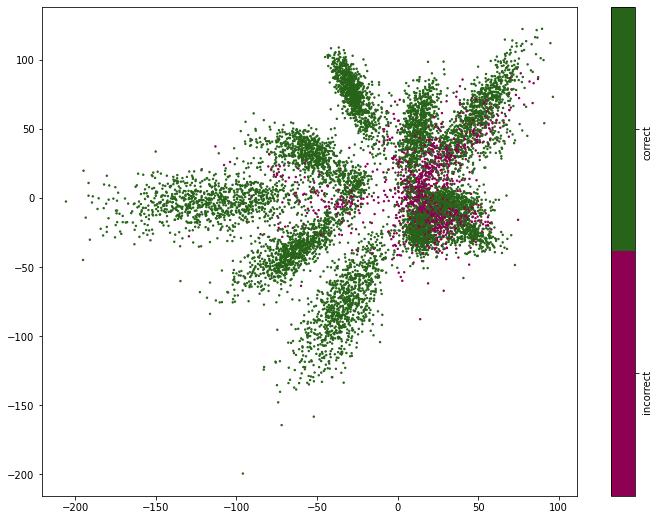

In [54]:
### Error Nodes
plt.figure(figsize=(12,9))
plt.scatter(embeddings[:,0], embeddings[:, 1], c=(labels==ilabels), s=2, cmap='PiYG')
cbar = plt.colorbar(ticks=range(10), #label='classes', 
                    boundaries=np.arange(3)-0.5)
cbar.set_ticks(np.arange(2))
cbar.set_ticklabels(['incorrect', 'correct', ])
cbar.ax.tick_params(rotation=90)

# mask = torch.nonzero(labels==ilabels)
# plt.scatter(embeddings[mask,0], embeddings[mask, 1], s=2, c='g', label='correct')
# mask = torch.nonzero(labels!=ilabels)
# plt.scatter(embeddings[mask,0], embeddings[mask, 1], s=2, c='orangered', label='incorrect')
# plt.legend()
# plt.savefig('./output/03_errors_fmnist.pdf')

In [55]:
## plot on a 2D map, the decision boundary
ng = 1000
_a,_b,_c,_d = embeddings[:,0].min()-0.1, embeddings[:,0].max()+0.1, embeddings[:,1].min()-0.1, embeddings[:,1].max()+0.1
xg, yg = torch.linspace(_a, _b, ng), torch.linspace(_c, _d, ng)
xg, yg = torch.meshgrid(xg, yg)
xyg = torch.stack([xg.reshape(-1), yg.reshape(-1)], dim=-1)

/home/tsuman/All_Files/Program_Files/miniconda/lib/python3.9/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [56]:
xyg.shape

torch.Size([1000000, 2])

In [60]:
BS = 1000
output, maxims = [], []
for i in range(0, len(xyg), BS):
    xx = xyg[i:i+BS].to(device)
    with torch.no_grad():
        yout = classifier[1](xx)
#         yout = classifier[1](xx, hard=True)
        output.append(torch.argmax(yout, dim=1).cpu())
        
#         dists = torch.cdist(xx, classifier[1].centers)
#         dists = dists/np.sqrt(classifier[1].input_dim) ### correction to make diagonal of unit square 1 in nD space

#         mask = torch.argmin(dists, dim=1) ## reusing embs.. it is one hot to select distance
#         mask = dists[torch.arange(len(mask), dtype=torch.long), mask]
#         maxims.append((mask*classifier[1].inv_temp).cpu())
        


output = torch.cat(output, dim=0)
maxims = torch.cat(maxims, dim=0)

NotImplementedError: There were no tensor arguments to this function (e.g., you passed an empty list of Tensors), but no fallback function is registered for schema aten::_cat.  This usually means that this function requires a non-empty list of Tensors, or that you (the operator writer) forgot to register a fallback function.  Available functions are [CPU, CUDA, QuantizedCPU, BackendSelect, Python, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradXLA, AutogradLazy, AutogradXPU, AutogradMLC, AutogradHPU, AutogradNestedTensor, AutogradPrivateUse1, AutogradPrivateUse2, AutogradPrivateUse3, Tracer, AutocastCPU, Autocast, Batched, VmapMode, Functionalize].

CPU: registered at aten/src/ATen/RegisterCPU.cpp:21063 [kernel]
CUDA: registered at aten/src/ATen/RegisterCUDA.cpp:29726 [kernel]
QuantizedCPU: registered at aten/src/ATen/RegisterQuantizedCPU.cpp:1258 [kernel]
BackendSelect: fallthrough registered at ../aten/src/ATen/core/BackendSelectFallbackKernel.cpp:3 [backend fallback]
Python: registered at ../aten/src/ATen/core/PythonFallbackKernel.cpp:47 [backend fallback]
Named: registered at ../aten/src/ATen/core/NamedRegistrations.cpp:7 [backend fallback]
Conjugate: registered at ../aten/src/ATen/ConjugateFallback.cpp:18 [backend fallback]
Negative: registered at ../aten/src/ATen/native/NegateFallback.cpp:18 [backend fallback]
ZeroTensor: registered at ../aten/src/ATen/ZeroTensorFallback.cpp:86 [backend fallback]
ADInplaceOrView: fallthrough registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:64 [backend fallback]
AutogradOther: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:11380 [autograd kernel]
AutogradCPU: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:11380 [autograd kernel]
AutogradCUDA: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:11380 [autograd kernel]
AutogradXLA: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:11380 [autograd kernel]
AutogradLazy: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:11380 [autograd kernel]
AutogradXPU: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:11380 [autograd kernel]
AutogradMLC: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:11380 [autograd kernel]
AutogradHPU: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:11380 [autograd kernel]
AutogradNestedTensor: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:11380 [autograd kernel]
AutogradPrivateUse1: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:11380 [autograd kernel]
AutogradPrivateUse2: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:11380 [autograd kernel]
AutogradPrivateUse3: registered at ../torch/csrc/autograd/generated/VariableType_3.cpp:11380 [autograd kernel]
Tracer: registered at ../torch/csrc/autograd/generated/TraceType_3.cpp:11220 [kernel]
AutocastCPU: fallthrough registered at ../aten/src/ATen/autocast_mode.cpp:461 [backend fallback]
Autocast: fallthrough registered at ../aten/src/ATen/autocast_mode.cpp:305 [backend fallback]
Batched: registered at ../aten/src/ATen/BatchingRegistrations.cpp:1059 [backend fallback]
VmapMode: fallthrough registered at ../aten/src/ATen/VmapModeRegistrations.cpp:33 [backend fallback]
Functionalize: registered at ../aten/src/ATen/FunctionalizeFallbackKernel.cpp:52 [backend fallback]


In [61]:
# maxims.shape

In [62]:
# xyg[:,0].reshape(xg.shape).shape,xyg[:,1].reshape(yg.shape).shape, maxims.reshape(xg.shape).shape

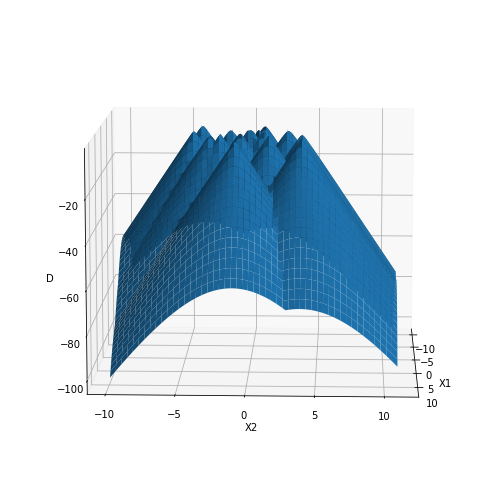

In [52]:
## plot 3D for the distance
%matplotlib inline
fig = plt.figure(figsize=(11,9))

ax = fig.gca(projection='3d')
ax.view_init(elev=10., azim=2)
ax.plot_surface(xyg[:,0].numpy().reshape(xg.shape),
                xyg[:,1].numpy().reshape(yg.shape),
                -maxims.cpu().numpy().reshape(xg.shape))
    
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('D')
plt.show()

In [53]:
# plt.figure(figsize=(12,9))
# plt.scatter(embeddings[:,0], embeddings[:, 1], c=ilabels, s=2, cmap='tab10')
# cf = plt.contourf(xyg[:,0].reshape(xg.shape),
#                  xyg[:,1].reshape(yg.shape),
#                  output.reshape(xg.shape), levels=9,
#                  alpha=0.5, cmap="tab10", antialiased=True)

In [54]:
### plot centroids as well

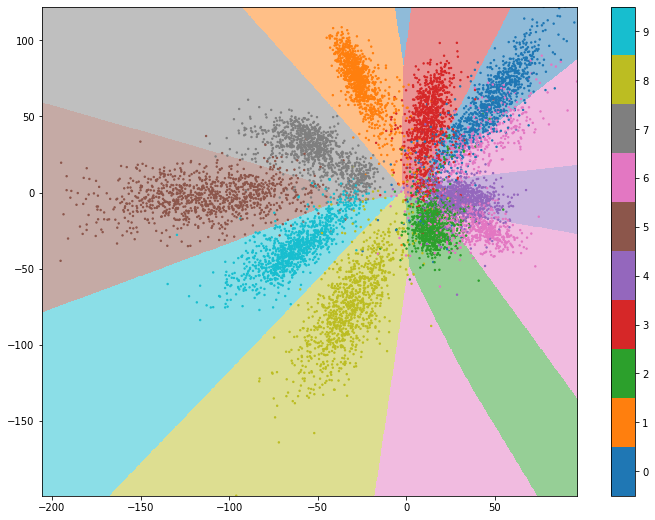

In [63]:
plt.figure(figsize=(12,9))
plt.scatter(embeddings[:,0], embeddings[:, 1], c=ilabels, s=2, cmap='tab10')

cbar = plt.colorbar(ticks=range(10), #label='classes', 
                    boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(list(range(10)))

plt.imshow(output.reshape(xg.shape).t(), interpolation='nearest',
           extent=(_a, _b, _c, _d),
           alpha=0.5, cmap='tab10',
           aspect='auto', origin='lower')

# plt.savefig('./output/04_DecisionBoundary_Class_fmnist.pdf')

In [56]:
## display different class boundary

BS = 1000
output2 = []
for i in range(0, len(xyg), BS):
    xx = xyg[i:i+BS].to(device)
    with torch.no_grad():
        yout = classifier[1](xx, hard=True)
        output2.append(torch.argmax(classifier[1].cls_confidence, dim=1).cpu())
output2 = torch.cat(output2, dim=0)

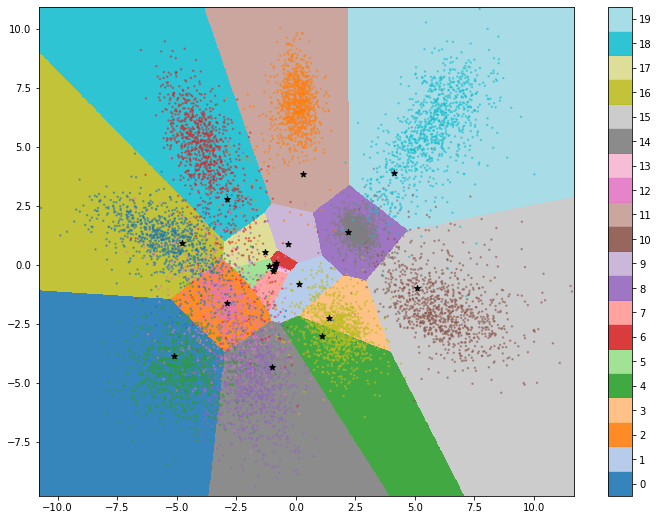

In [67]:
plt.figure(figsize=(12,9))
plt.scatter(embeddings[:,0], embeddings[:, 1], c=ilabels, s=2, cmap='tab10', alpha=0.5)

plt.imshow(output2.reshape(xg.shape).t(), interpolation='nearest',
           extent=(_a, _b, _c, _d),
           alpha=0.9, cmap='tab20',
           aspect='auto', origin='lower')

cbar = plt.colorbar(ticks=range(20), #label='classes', 
                    boundaries=np.arange(21)-0.5)
cbar.set_ticks(np.arange(20))
cbar.set_ticklabels(list(range(20)))

### plot centroids as well
plt.scatter(*classifier[1].centers.data.cpu().numpy().T, marker='*', c='k')

plt.savefig('./output/05_DecisionBoundary_Sets_fmnist.pdf')

### Hard train accuracy with count per classifier

In [58]:
test_count = 0
test_acc = 0
# set_count = torch.zeros(classifier.num_sets).to(device)
set_count = torch.zeros(classifier[1].num_sets).to(device)
for xx, yy in tqdm(train_loader):
    xx, yy = xx.to(device), yy.to(device)
    with torch.no_grad():
#         yout = classifier(model(xx), hard=True)
        yout = classifier[1](classifier[0](model(xx)), hard=True)
        
#         set_indx, count = torch.unique(torch.argmax(classifier.cls_confidence, dim=1), return_counts=True) 
        set_indx, count = torch.unique(torch.argmax(classifier[1].cls_confidence, dim=1), return_counts=True) 
        set_count[set_indx] += count
    outputs = torch.argmax(yout, dim=1).data.cpu().numpy()
    correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
    test_acc += correct
    test_count += len(xx)

print(f'Hard Train Acc:{float(test_acc)/test_count*100:.2f}%')
print(set_count.type(torch.long).tolist())

100%|██████████| 1200/1200 [00:03<00:00, 347.83it/s]

Hard Train Acc:93.99%
[5899, 390, 5847, 2948, 2661, 126, 9, 114, 6063, 46, 0, 5893, 0, 2, 5928, 5988, 6044, 287, 5802, 5953]


In [59]:
#### Classifiers that enclose any data
torch.count_nonzero(set_count)

tensor(18, device='cuda:0')

In [ ]:
#### classifier with class representation
torch.argmax(classifier[1].cls_weight, dim=1)

In [ ]:
# The class labels are same as that of initialized
# tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3,
#         4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7,
#         8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1,
#         2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5,
#         6, 7, 8, 9], device='cuda:0')

In [ ]:
classifier[1].cls_weight

In [ ]:
# torch.unique(torch.argmax(classifier.cls_confidence, dim=1), return_counts=True)

In [ ]:
classifier[1].inv_temp

In [ ]:
### example output per classifier
yout[5]

In [ ]:
asdfsdf ## to break the code

## UMAP - Viz

In [64]:
import umap

2022-08-11 09:42:01.475197: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [65]:
imgs, labels = [], []
for xx, yy in tqdm(train_loader):
    imgs.append(xx)
    labels.append(yy)

imgs = torch.cat(imgs, dim=0)
labels = torch.cat(labels, dim=0)

100%|███████████████████████████████████████████████| 1200/1200 [00:01<00:00, 1175.66it/s]


In [66]:
embed = umap.UMAP(n_neighbors=100, n_components=2, min_dist=0.1, spread=1, metric="euclidean")
# embed = umap.UMAP(n_neighbors=784, n_components=2, min_dist=0.1, spread=1,
# #                   target_metric='euclidean',
#                   target_metric='categorical',
#                   target_weight=0.1
#                  )

In [68]:
embedding = embed.fit_transform(imgs.numpy().reshape(-1, 28*28))

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [69]:
imgs_, labels_ = [], []
for xx, yy in tqdm(test_loader):
    imgs_.append(xx)
    labels_.append(yy)

imgs_ = torch.cat(imgs_, dim=0)
labels_ = torch.cat(labels_, dim=0)

100%|██████████████████████████████████████████████████| 200/200 [00:00<00:00, 574.84it/s]


In [70]:
embedding_ = embed.transform(imgs_.numpy().reshape(-1, 28*28))

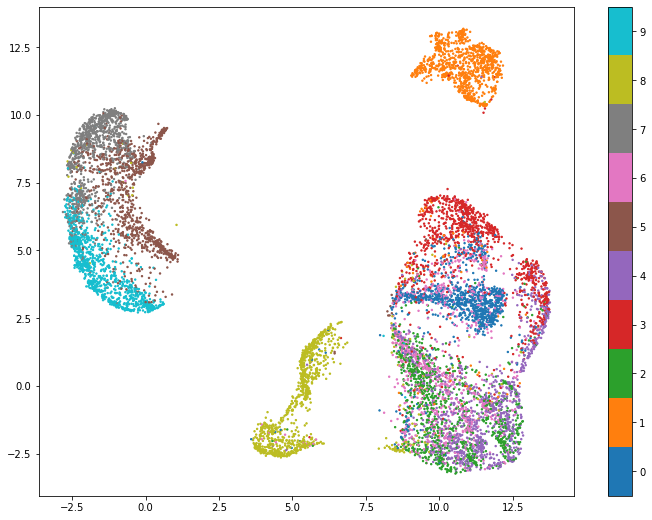

In [71]:
plt.figure(figsize=(12,9))

plt.scatter(embedding_[:,0], embedding_[:, 1], c=labels_, s=2, cmap="tab10")

cbar = plt.colorbar(ticks=range(10), #label='classes', 
                    boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(list(range(10)))

### plot centroids as well
# plt.scatter(*classifier[1].centers.data.cpu().numpy().T, marker='*', c='k')
# plt.scatter(*classifier.centers.data.cpu().numpy().T, marker='*', c='k')

# plt.xlim(xg.min(), xg.max())
# plt.ylim(yg.min(), yg.max()) 
plt.savefig('./output/UMAP_fmnist.pdf')

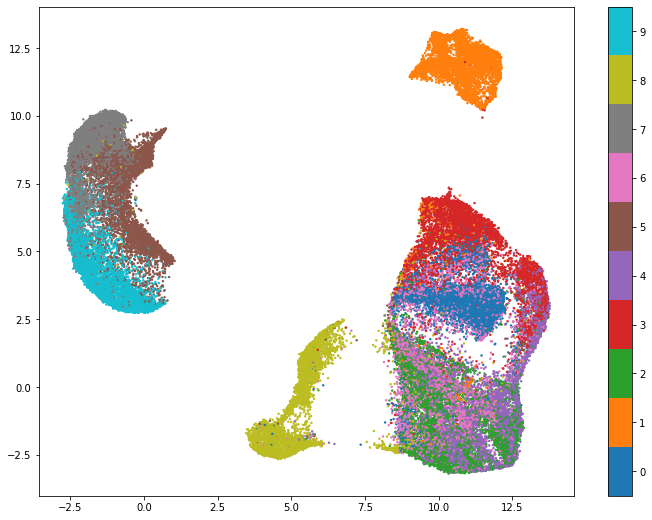

In [72]:
plt.figure(figsize=(12,9))

plt.scatter(embedding[:,0], embedding[:, 1], c=labels, s=2, cmap="tab10")

cbar = plt.colorbar(ticks=range(10), #label='classes', 
                    boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(list(range(10)))

### plot centroids as well
# plt.scatter(*classifier[1].centers.data.cpu().numpy().T, marker='*', c='k')
# plt.scatter(*classifier.centers.data.cpu().numpy().T, marker='*', c='k')

# plt.xlim(xg.min(), xg.max())
# plt.ylim(yg.min(), yg.max()) 
plt.savefig('./output/UMAP_fmnist_train.pdf')

## Visualize embeddings for MNIST dataset

In [ ]:
def get_mnist_data_loaders():
    mnist = datasets.MNIST()
    # mnist.download_mnist()
    # mnist.save_mnist()
    train_data, train_label_, test_data, test_label_ = mnist.load()

    train_data = train_data / 255.
    test_data = test_data / 255.

    # train_label = tnn.Logits.index_to_logit(train_label_)
    train_size = len(train_label_)

    ## converting data to pytorch format
    train_data = torch.Tensor(train_data)
    test_data = torch.Tensor(test_data)
    train_label = torch.LongTensor(train_label_)
    test_label = torch.LongTensor(test_label_)

    input_size = 784
    output_size = 10

    class MNIST_Dataset2(data.Dataset):

        def __init__(self, data, label):
            self.data = data.reshape(-1, 1, 28, 28)
            self.label = label

    #         self.label = mask.type(torch.float32).reshape(-1,1)
            self._shuffle_data_()

        def __len__(self):
            return len(self.data)

        def _shuffle_data_(self):
            randidx = random.sample(range(len(self.data)), k=len(self.data))
            self.data = self.data[randidx]
            self.label = self.label[randidx]

        def __getitem__(self, idx):
            img, lbl = self.data[idx], self.label[idx]
            return img, lbl

    train_dataset = MNIST_Dataset2(train_data, train_label)
    test_dataset = MNIST_Dataset2(test_data, test_label)

    train_loader = data.DataLoader(dataset=train_dataset, num_workers=4, batch_size=batch_size, shuffle=True)
    test_loader = data.DataLoader(dataset=test_dataset, num_workers=4, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

In [ ]:
#### Find embedding for mnist dataset

_, test_loader2 = get_mnist_data_loaders()

embeddings_, labels_, ilabels_ = [], [], []
model.eval()
for xx, yy in tqdm(test_loader2):
    ilabels_.append(yy)
    xx, yy = xx.to(device), yy.to(device)
    with torch.no_grad():
#         yout = classifier(model(xx), hard=True)
        embs = classifier[0](model(xx))
        embeddings_.append(embs.cpu())
        
        yout = classifier[1](embs, hard=True)
        labels_.append(torch.argmax(yout, dim=1).cpu())
        
embeddings_ = torch.cat(embeddings_, dim=0)
labels_ = torch.cat(labels_, dim=0)
ilabels_ = torch.cat(ilabels_, dim=0)

In [ ]:
plt.figure(figsize=(12,9))
plt.scatter(embeddings[:,0], embeddings[:, 1], c=ilabels, s=2, cmap='tab10')
plt.imshow(output2.reshape(xg.shape).t(), interpolation='nearest',
           extent=(_a, _b, _c, _d),
           alpha=0.5, cmap='tab20',
           aspect='auto', origin='lower')
### plot centroids as well
plt.scatter(*classifier[1].centers.data.cpu().numpy().T, marker='*', c='k')

plt.scatter(embeddings_[:,0], embeddings_[:, 1], c='k', s=2,  cmap='tab10')
# plt.savefig('./output/06_mnist_on_fmnist_plot.pdf')

### analyze per classifier accuracy

In [ ]:
test_count = 0
test_acc = 0
set_count = torch.zeros(classifier.num_sets).to(device)
set_acc = torch.zeros(classifier.num_sets).to(device)
for xx, yy in tqdm(train_loader):
    xx, yy = xx.to(device), yy.to(device)
    with torch.no_grad():
        yout = classifier(model(xx), hard=True)
        
    cls_indx = torch.argmax(classifier.cls_confidence, dim=1)
    set_indx, count = torch.unique(cls_indx, return_counts=True) 
    set_count[set_indx] += count
    
    outputs = torch.argmax(yout, dim=1).data.cpu().numpy()
    correct = (outputs == yy.data.cpu().numpy()).astype(float)
    
    ### class_index has 100 possible values
    for i, c in enumerate(correct):
        set_acc[cls_indx[i]] += c
    
#     print(set_acc.sum(), set_count.sum())
#     break
    test_acc += correct.sum()
    test_count += len(xx)

print(f'Hard Train Acc:{float(test_acc)/test_count*100:.2f}%')
print(set_count.type(torch.long).tolist())

In [ ]:
set_acc/set_count

In [ ]:
for i, (cnt, acc, cls) in enumerate(zip(set_count.type(torch.long).tolist(),
                                   (set_acc/set_count).tolist(),
                                   torch.argmax(classifier.cls_weight, dim=1).tolist())):
    if cnt == 0: continue
    print(f"{i},\t {cnt},\t {cls}\t {acc*100:.2f}%")

### Benchmark - Robustness

In [ ]:
import foolbox as fb
import foolbox.attacks as fa

In [ ]:
epsilons = [0.001, 0.01, 0.03, 0.1, 0.3, 0.5, 1.0]
# epsilons = [0.0005, 0.001, 0.0015, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.1, 0.3, 0.5, 1.0,]

#### Benchmark on full dataset

In [ ]:
attacks = [
    fa.FGSM(),
    fa.LinfPGD(),
    fa.LinfBasicIterativeAttack(),
#     fa.LinfAdditiveUniformNoiseAttack(),
#     fa.LinfDeepFoolAttack(),
]
atk_names = [
    "FGSM", 
    "LinfPGD", 
    "LinfBasicIterativeAttack", 
#     "LinfAdditiveUniformNoiseAttack", 
#     "LinfDeepFoolAttack",
]

In [ ]:
def get_attack_success(model, attack, dataloader):
    fmodel = fb.PyTorchModel(model.eval(), bounds=(-1, 1), device=device)
    success_per_eps = []

    for eps in epsilons:
        count = 0
        total = 0
        print(f"Running one epoch attack for eps: {eps}")
        for i, (images, labels) in enumerate(tqdm(dataloader)):
            images, labels = images.to(device), labels.to(device)
            _, _, success = attack(fmodel, images, labels, epsilons=[eps])
            count += int(torch.count_nonzero(success))
            total += torch.numel(success)
#             break
        success_per_eps.append(count/total)
    return success_per_eps

In [ ]:
# get_attack_success(model, attacks[0], test_loader)

### Compute the robustness

In [ ]:
# outputs = {}

# model_ = nn.Sequential(model, classifier)

# model_.eval()
# ### load model and compute attack_success
# for j in range(len(attacks)):
#     attack = attacks[j]
#     atname = atk_names[j]

#     print(f"Attacking on model using {atname}")
#     succ_eps = get_attack_success(model_, attack, test_loader)
#     outputs[atname] = succ_eps
#     print(f"Success rate is : {succ_eps}")

In [ ]:
torch.cuda.current_device()

In [ ]:
# torch.cuda.set_device(1)

### View the embedding space

In [ ]:
model_ = nn.Sequential(model, classifier)
fmodel = fb.PyTorchModel(model_.eval(), bounds=(-1, 1), device=device)
fmodel.device = device

attack = attacks[0]
eps = epsilons[0]
print(f"Running one epoch attack for eps: {eps}")

true_emb, attk_emb = [], []
true_lbl, attk_lbl = [], []

count = 0
total = 0

for i, (images, labels) in enumerate(tqdm(test_loader)):
    images, labels = images.to(device), labels.to(device)
    _, adv, success = attack(fmodel, images, labels, epsilons=[eps])
    count += int(torch.count_nonzero(success))
    total += torch.numel(success)
    break

In [ ]:
adv[0].shape

In [ ]:
plt.imshow(adv[0][0,0].cpu())

In [ ]:
plt.imshow(images[0,0].cpu())

In [ ]:
model_ = nn.Sequential(model, classifier)
fmodel = fb.PyTorchModel(model_.eval(), bounds=(-1, 1), device=device)
fmodel.device = device

ai = 0
attack = attacks[ai]

eps = epsilons[0]
print(f"Running one epoch attack for eps: {eps}, [{atk_names[ai]}]")


true_emb, attk_emb = [], []
true_lbl, attk_lbl = [], []

count = 0
total = 0
for xx, yy in tqdm(test_loader):
    xx, yy = xx.to(device), yy.to(device)
    embs = classifier[0](model(xx))
    
    true_emb.append(embs.data.cpu())
    
    yout = classifier[1](embs)
    true_lbl.append(torch.argmax(yout, dim=1).data.cpu())
    
    _, adv, success = attack(fmodel, xx, yy, epsilons=[eps])
    embs = classifier[0](model(adv[0]))
    attk_emb.append(embs.data.cpu())
    
    yout = classifier[1](embs)
    attk_lbl.append(torch.argmax(yout, dim=1).data.cpu())
    
    count += int(torch.count_nonzero(success))
    total += torch.numel(success)

In [ ]:
true_emb = torch.cat(true_emb, dim=0)
attk_emb = torch.cat(attk_emb, dim=0)
true_lbl = torch.cat(true_lbl, dim=0)
attk_lbl = torch.cat(attk_lbl, dim=0)

In [ ]:
print(count/total)

In [ ]:
plt.figure(figsize=(12,9))
# plt.scatter(embeddings[:,0], embeddings[:, 1], c=ilabels, s=2, cmap='tab10')
plt.imshow(output.reshape(xg.shape).t(), interpolation='nearest',
           extent=(_a, _b, _c, _d),
           alpha=0.5, cmap='tab10',
           aspect='auto', origin='lower')

plt.scatter(true_emb[:,0], true_emb[:, 1], c=attk_lbl, s=2, cmap='tab10')
# plt.scatter(attk_emb[:,0], attk_emb[:, 1], c=true_lbl, s=2, cmap='tab10')